In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from realclearpolling import * 
import requests

### Brownian Motion Regression Model

$Y_i = b_0 + b_{m(i)} + c_1r(t(i)) + B(t(i)) + \epsilon_i$

$E[B(t)] = 0$



In [3]:
#Grab the betting data

url = 'https://www.realclearpolitics.com/json/odds/event_106_final.json?'
response = requests.get(url)
data = response.json()

def get_candidate_odds(data, candidate):
    nlist = []
    for i in range(len(data)):
        values = data[i]['candidates']
        for value in values:
            if value['name'] == candidate:
                nlist.append(value['value'])
    return nlist 

def get_dates(data):
    nlist = []
    for i in range(len(data)):
        nlist.append(data[i]['date_r'])
    return nlist

dates = get_dates(data['poll']['rcp_avg'])
trump_odds = get_candidate_odds(data['poll']['rcp_avg'], 'Donald Trump')
biden_odds = get_candidate_odds(data['poll']['rcp_avg'], 'Joe Biden')

bet_df = pd.DataFrame({'date': dates, 'trump': trump_odds, 'biden': biden_odds})
bet_df['date'] = pd.to_datetime(bet_df['date'],utc=True)
bet_df['date'] = bet_df['date'].dt.date
bet_df['biden_rolling'] = bet_df['biden'].rolling(window=1).mean()
bet_df['trump_rolling'] = bet_df['trump'].rolling(window=1).mean()
bet_df.sort_values(by='date', inplace=True)

#Polling Data
rcp = clean_data(get_poll_data())

In [4]:
bet_df.head()

,date,trump,biden,biden_rolling,trump_rolling
459,2023-01-03,14.3,27.7,27.7,14.3
458,2023-01-04,14.6,28.0,28.0,14.6
457,2023-01-05,15.2,28.0,28.0,15.2
456,2023-01-06,14.8,28.0,28.0,14.8
455,2023-01-09,15.2,27.4,27.4,15.2


In [5]:
rcp.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
0,Morning Consult,4/5 - 4/7,6236 RV,1.0,44.0,43.0,Trump+1,1.0,RV,6236,2024-04-07,4,2024,462
1,Reuters/Ipsos,4/3 - 4/7,833 RV,4.0,37.0,41.0,Biden+4,-4.0,RV,833,2024-04-07,4,2024,462
2,I&I/TIPP,4/3 - 4/5,1265 RV,2.8,40.0,43.0,Biden+3,-3.0,RV,1265,2024-04-05,4,2024,460
3,Emerson,4/2 - 4/3,1438 RV,2.5,46.0,45.0,Trump+1,1.0,RV,1438,2024-04-03,4,2024,458
4,Rasmussen Reports,3/31 - 4/2,1099 LV,3.0,49.0,41.0,Trump+8,8.0,LV,1099,2024-04-02,4,2024,457


In [6]:
# Convert 'End Date' column to datetime format
rcp['End Date'] = pd.to_datetime(rcp['End Date'])
bet_df['date'] = pd.to_datetime(bet_df['date'])

# Merge dataframes on date
merged = pd.merge(rcp, bet_df, left_on='End Date', right_on='date')
merged.head()

,pollster,date_x,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23,date_y,trump,biden,biden_rolling,trump_rolling
0,Morning Consult,4/5 - 4/7,6236 RV,1.0,44.0,43.0,Trump+1,1.0,RV,6236,2024-04-07,4,2024,462,2024-04-07,43.6,41.0,41.0,43.6
1,Reuters/Ipsos,4/3 - 4/7,833 RV,4.0,37.0,41.0,Biden+4,-4.0,RV,833,2024-04-07,4,2024,462,2024-04-07,43.6,41.0,41.0,43.6
2,I&I/TIPP,4/3 - 4/5,1265 RV,2.8,40.0,43.0,Biden+3,-3.0,RV,1265,2024-04-05,4,2024,460,2024-04-05,43.4,40.6,40.6,43.4
3,Emerson,4/2 - 4/3,1438 RV,2.5,46.0,45.0,Trump+1,1.0,RV,1438,2024-04-03,4,2024,458,2024-04-03,44.3,39.0,39.0,44.3
4,Rasmussen Reports,3/31 - 4/2,1099 LV,3.0,49.0,41.0,Trump+8,8.0,LV,1099,2024-04-02,4,2024,457,2024-04-02,44.5,38.8,38.8,44.5


In [33]:
merged.to_csv('/Users/robbiefeldstein/Documents/Programming/Election2024/RFolder/merged.csv')

/Users/robbiefeldstein/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


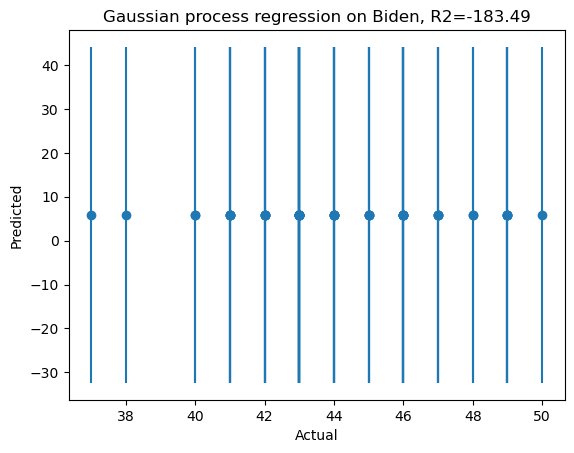

In [32]:
#Start a Gaussian Process Regression on just Biden

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = merged[["Days Since 01-01-23"]]
X = pd.get_dummies(X,drop_first=True)
y = merged["Biden (D)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#What on Earth should the kernel be?
kernel = RBF() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

gp.fit(X_train, y_train)

y_pred_tr, y_pred_tr_std = gp.predict(X_train, return_std=True)
y_pred_te, y_pred_te_std = gp.predict(X_test, return_std=True)

#Plot the predictions overtime

plt.figure()
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
plt.title('Gaussian process regression on Biden, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [24]:
len(y_pred_tr)

225